# DA-DAN Modulation Analysis Project

### Set-Up

In [1]:
import navis
import fafbseg
import flybrains

import numpy as np
import seaborn as sns
import itertools
import pandas as pd
from tqdm import tqdm
from functools import reduce
from tabulate import tabulate
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.gridspec as gridspec
import hvplot.pandas
from bokeh.plotting import figure, show, output_notebook


import scipy
import networkx as nx

import IProgress

import pyroglancer
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer, set_flywireviewerstate

import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC
from navis.interfaces.neuprint import fetch_adjacencies, fetch_synapse_connections

from pyroglancer.layers import create_nglayer, setlayerproperty
from pyroglancer.ngviewer import openviewer, closeviewer,setviewerstate, get_ngscreenshot
from pyroglancer.ngspaces import create_ngspace
from pyroglancer.createconfig import createconfig

from neuprint import fetch_synapses, NeuronCriteria as NC, SynapseCriteria as SC

from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection



import gspread

/Users/User/CODING/Uni/2024_DANModulation/DANModulation/lib/python3.11/site-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [2]:
### Code by Sri
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
### fixes PDF export
mpl.rcParams['pdf.use14corefonts']=True
mpl.rcParams['font.sans-serif'] = ['Helvetica',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Computer Modern Sans Serif',
                                   'Lucida Grande',
                                   'Verdana',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',                                          
                                   'Avant Garde',
                                   'sans-serif']
mpl.rcParams['font.size'] = 11


In [4]:
label_fontsize = 16 
title_fontsize = 18

figwidth_size = 5
figheigth_size = 5


In [5]:
#navis display options for frontal view..
elev = -180
azim = -90
dist = 6


In [6]:
print('navis version :',navis.__version__)
print('fafbseg version :',fafbseg.__version__)
print('flybrains version :',flybrains.__version__)
print('pyroglancer version :',pyroglancer.__version__)


navis version : 1.5.0
fafbseg version : 3.0.0
flybrains version : 0.2.9
pyroglancer version : 0.0.5


### Fetch data from Neuprint

In [7]:
## using dotenv to import Janelia PAT
from dotenv import load_dotenv
import os
load_dotenv()

## fetching Janelia client
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1', token=os.environ.get("JANELIA_PAT"))
client

Client("https://neuprint.janelia.org", "hemibrain:v1.2.1")

In [8]:
### print roi hierarchy
rois = neu.fetch_roi_hierarchy(False,True,'text')
print(rois)

hemibrain
 +-- AL(L)*
 +-- AL(R)*
 +-- AOT(R)
 +-- CX
 |   +-- AB(L)*
 |   +-- AB(R)*
 |   +-- EB*
 |   +-- FB*
 |   +-- NO*
 |   +-- PB*
 +-- GC
 +-- GF(R)
 +-- GNG*
 +-- INP
 |   +-- ATL(L)*
 |   +-- ATL(R)*
 |   +-- CRE(L)*
 |   +-- CRE(R)*
 |   +-- IB*
 |   +-- ICL(L)*
 |   +-- ICL(R)*
 |   +-- SCL(L)*
 |   +-- SCL(R)*
 +-- LH(R)*
 +-- LX(L)
 |   +-- BU(L)*
 |   +-- LAL(L)*
 +-- LX(R)
 |   +-- BU(R)*
 |   +-- LAL(R)*
 +-- MB(+ACA)(R)
 |   +-- MB(R)
 |   |   +-- CA(R)*
 |   |   +-- PED(R)*
 |   |   +-- a'L(R)*
 |   |   +-- aL(R)*
 |   |   +-- b'L(R)*
 |   |   +-- bL(R)*
 |   |   +-- gL(R)*
 |   +-- dACA(R)
 |   +-- lACA(R)
 |   +-- vACA(R)
 +-- MB(L)
 |   +-- CA(L)*
 |   +-- a'L(L)*
 |   +-- aL(L)*
 |   +-- b'L(L)*
 |   +-- bL(L)*
 |   +-- gL(L)*
 +-- OL(R)
 |   +-- AME(R)*
 |   +-- LO(R)*
 |   +-- LOP(R)*
 |   +-- ME(R)*
 +-- PENP
 |   +-- CAN(R)*
 |   +-- FLA(R)*
 |   +-- PRW*
 |   +-- SAD*
 +-- POC
 +-- SNP(L)
 |   +-- SIP(L)*
 |   +-- SMP(L)*
 +-- SNP(R)
 |   +-- SIP(R)*
 |   +-

## Analysis

#### Get PAM neurons from hemibrains and fetch their connections

In [9]:
## fetch all neurons containing "PAM" from hemibrain dataset
pamneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type="^PAM.*",regex=True)) 

In [78]:
uniquePAMTypes = pamneurons_df.type.unique()
print(uniquePAMTypes)

['PAM09' 'PAM10' 'PAM04_a' 'PAM04_b' 'PAM01_b' 'PAM11' 'PAM01_a' 'PAM05'
 'PAM08_c' 'PAM08_e' 'PAM02' 'PAM06_b' 'PAM14' 'PAM13' 'PAM06_a' 'PAM08_b'
 'PAM12' 'PAM03' 'PAM08_a' 'PAM07' 'PAM08_d' 'PAM15_a' 'PAM15_b']


In [308]:
def getFilteredConnections(typeA = "^PAM.*",typeB = "^PAM.*", minWeight = 1, silent = True):
    neuron_df, conn_df = fetch_adjacencies(NC(status='Traced',type=typeA,regex=True), NC(status='Traced',type=typeB,regex=True))
    conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type', 'instance'])
    filteredConnections=conn_df[conn_df['weight']>=minWeight]
    filteredConnections.sort_values('weight', ascending=False)
    if not silent:
        print(neuron_df)
        print(conn_df)

    return filteredConnections

In [302]:
filteredConnections = getFilteredConnections(silent=False)

  0%|          | 0/2 [00:00<?, ?it/s]

      bodyId_pre  bodyId_post     roi  weight type_pre    instance_pre  \
0      268725517    298595394   bL(R)       2    PAM09  PAM09(B1ped)_L   
1      268725517    298595394  b'L(R)       1    PAM09  PAM09(B1ped)_L   
2      268725517    298595394   bL(L)       1    PAM09  PAM09(B1ped)_L   
3      268725517    299613480   bL(R)       1    PAM09  PAM09(B1ped)_L   
4      268725517    328253133   bL(L)       1    PAM09  PAM09(B1ped)_L   
...          ...          ...     ...     ...      ...             ...   
7760  5901205545   5812982120  b'L(L)       2    PAM05   PAM05(B'2p)_L   
7761  5901205545   5812983399  b'L(L)       4    PAM05   PAM05(B'2p)_L   
7762  5901205545   5813047784  b'L(L)       3    PAM05   PAM05(B'2p)_L   
7763  5901205545   5813069965  b'L(L)       1    PAM05   PAM05(B'2p)_L   
7764  5901205545   5813091420  b'L(L)       2    PAM05   PAM05(B'2p)_L   

     type_post   instance_post  
0        PAM10     PAM10(B1)_R  
1        PAM10     PAM10(B1)_R  
2        PAM

In [303]:
### extract unique neurons
uniquePAMNeuronsPre = filteredConnections["instance_pre"].unique()
print(uniquePAMNeuronsPre)
uniquePAMNeuronsPost = filteredConnections["instance_post"].unique()
print("")
print(uniquePAMNeuronsPost)

['PAM09(B1ped)_L' 'PAM10(B1)_R' 'PAM09(B1ped)_R' 'PAM10(B1)_L'
 'PAM04_a(B2)_R' 'PAM04_b(B2)_R' 'PAM01_b(y5)_R' 'PAM11(a1)_R'
 'PAM01_a(y5)_R' "PAM05(B'2p)_R" 'PAM01_a(y5)_L' 'PAM04_a(B2)_L'
 'PAM11(a1)_L' 'PAM08_c(y4)_R' 'PAM08_e(y4)_R' 'PAM01_b(y5)_L'
 "PAM02(B'2a)_L" "PAM05(B'2p)_L" "PAM06_b(B'2m)_R" "PAM14(B'1m)_R"
 "PAM13(B'1ap)_R" "PAM06_a(B'2m)_R" "PAM06_a(B'2m)_L" "PAM02(B'2a)_R"
 "PAM14(B'1m)_L" "PAM13(B'1ap)_L" 'PAM08_b(y4)_L' "PAM06_b(B'2m)_L"
 'PAM12(y3)_R' "PAM03(B2B'2a)_L" 'PAM12(y3)_L' 'PAM08_e(y4)_L'
 'PAM08_b(y4)_R' 'PAM08_c(y4)_L' 'PAM08_a(y4)_R' 'PAM07(y4<y1y2)_L'
 'PAM08_a(y4)_L' 'PAM07(y4<y1y2)_R' "PAM03(B2B'2a)_R" 'PAM08_d(y4)_R'
 "PAM15_a(y5B'2a)_L" "PAM15_b(y5B'2a)_R" 'PAM04_b(B2)(ADM02)_L'
 'PAM08_d(y4)_L' "PAM15_b(y5B'2a)_L" "PAM15_a(y5B'2a)_R"]

['PAM10(B1)_R' 'PAM09(B1ped)_R' 'PAM11(a1)_R' 'PAM10(B1)_L' 'PAM11(a1)_L'
 'PAM09(B1ped)_L' 'PAM12(y3)_R' 'PAM04_a(B2)_L' 'PAM04_a(B2)_R'
 'PAM01_a(y5)_R' "PAM15_b(y5B'2a)_R" "PAM02(B'2a)_R" 'PAM08_c(y4)_R'
 'PAM01_a(

#### Heatmap Visualization of PAM-PAM connections

In [306]:
#### visualize as matrix
matrix = neu.connection_table_to_matrix(filteredConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title).opts(xrotation=60)


:HeatMap   [columns,index]   (value)

In [283]:
### collapse PAM types and then show as matrix

PAMCollapsedConnections = filteredConnections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)

matrix = neu.connection_table_to_matrix(PAMCollapsedConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title = title+" -- PAM Types Collapsed").opts(xrotation=60)

:HeatMap   [columns,index]   (value)

In [284]:
### show unique neurons as matrix
matrix = neu.connection_table_to_matrix(filteredConnections, 'instance', sort_by='instance',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title+" -- PAM neurons").opts(xrotation=60)


:HeatMap   [columns,index]   (value)

#### detailed connection analysis

In [411]:
### extracts dendrites and axons for a specific PAM type and returns them as a dataframe
def extractDendritesPerType(target = "PAM05", connections=filteredConnections):
    target_pattern = target+r'\_?.?'
    dendrites = connections[connections['type_post'].str.contains(target_pattern, regex=True)]
    #print(dendrites)
    return dendrites

### extracts dendrites and axons for a specific PAM type and returns them as a dataframe
def extractAxonsPerType(target = "PAM05", connections=filteredConnections):
    target_pattern = target+r'\_?.?'
    axons = connections[connections['type_pre'].str.contains(target_pattern, regex=True)]
    #print(axons)
    return axons

## extracts dataframe of unique connection partners in a dataframe that has connections (e.g. dendrites or axons dataframe)
## takes type : 'pre' or 'post' and partnerType : 'instance' or 'type' or 'bodyId', 'typemerged' acts like type but merges PAM neuron subgroups (e.g. PAM04_a, PAM04_b -> PAM04)
def extractUniqueConnectionPartners(connections, type = "pre", partnerType = "instance",mergePAMSubtypes = False):
    if mergePAMSubtypes:
        connections = connections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)
    connectionpartners = connections[partnerType+'_'+type].unique()
    return connectionpartners

def listUniqueConnectionPartners(connections, type = "pre", printOut = True):
    typePartners = extractUniqueConnectionPartners(connections,type=type,partnerType="type")
    instancePartners = extractUniqueConnectionPartners(connections,type=type,partnerType="instance")
    bodyIdPartners = extractUniqueConnectionPartners(connections,type=type,partnerType="bodyId")
    if printOut: 
        print("Unique connection partners")
        print("by type")
        print(typePartners)
        print("by instance")
        print(instancePartners)
        print("by bodyId")
        print(bodyIdPartners)
    return typePartners, instancePartners, bodyIdPartners

print("Printing unique connection partners of PAM04 neurons")
typePartners, instancePartners, bodyIdPartners = listUniqueConnectionPartners(extractDendritesPerType("PAM04"))

Printing unique connection partners of PAM04 neurons
Unique connection partners
by type
['PAM10' 'PAM09' 'PAM04_a' 'PAM04_b' 'PAM11' 'PAM01_a' 'PAM13' 'PAM14'
 'PAM06_a' 'PAM06_b' 'PAM03' 'PAM12' 'PAM02' 'PAM08_b' 'PAM08_d' 'PAM05'
 'PAM15_a' 'PAM01_b' 'PAM15_b']
by instance
['PAM10(B1)_R' 'PAM09(B1ped)_R' 'PAM04_a(B2)_R' 'PAM04_b(B2)_R'
 'PAM11(a1)_R' 'PAM01_a(y5)_L' 'PAM10(B1)_L' 'PAM04_a(B2)_L'
 'PAM01_a(y5)_R' 'PAM09(B1ped)_L' "PAM13(B'1ap)_R" 'PAM11(a1)_L'
 "PAM14(B'1m)_R" "PAM13(B'1ap)_L" "PAM06_a(B'2m)_L" "PAM06_b(B'2m)_R"
 "PAM03(B2B'2a)_L" "PAM14(B'1m)_L" "PAM03(B2B'2a)_R" 'PAM12(y3)_L'
 "PAM02(B'2a)_R" 'PAM08_b(y4)_L' 'PAM08_d(y4)_R' "PAM05(B'2p)_R"
 "PAM15_a(y5B'2a)_L" 'PAM01_b(y5)_L' "PAM02(B'2a)_L"
 'PAM04_b(B2)(ADM02)_L' "PAM15_b(y5B'2a)_R" "PAM06_b(B'2m)_L"
 "PAM06_a(B'2m)_R"]
by bodyId
[ 328546871  359586213  359598627  422682603  453380528  455431209
  456846996  482762280  484735678  512765910  513451621  550408954
  551113395  551445253  551790504  551790913  5813325

In [435]:

## takes type : 'pre' or 'post' and partnerType : 'instance' or 'type' or 'bodyId'
def collapseConnections(connections, type="pre", partnerType="type",mergePAMSubtypes = False, mergePAMs = False):
    if mergePAMSubtypes:
        connections = connections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)
    if mergePAMs:
        connections[partnerType + '_' + type] = connections[partnerType + '_' + type].replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM', regex=True)
    # Group the connections by the specified partnerType and type, then sum the weights
    grouped = connections.groupby([partnerType + '_' + type]).agg({'weight': 'sum'}).reset_index()
    # Rename the columns to reflect the collapsed data
    grouped.columns = [partnerType + '_' + type, 'total_weight']
    return grouped.sort_values('total_weight', ascending=False)

In [420]:
### for each target in targets, this extracts weights of synaptic connections in each neuron type called 'target'
def extractUniquePartnerConnectionStrengthIterated(targets,connections=filteredConnections,type="pre", partnerType="type",connectionType = "dendrites", normalized = True, etc = True, etcTreshhold=0.03,mergePAMSubtypes=False):
    connectionsTable = pd.DataFrame()
    for target in targets:
        targetConnections = extractUniquePartnerConnectionStrength(target, connections=connections, type=type, partnerType=partnerType,connectionType = connectionType, normalized = normalized, etc = etc, etcTreshhold=0.03, mergePAMSubtypes=mergePAMSubtypes)
        if connectionsTable.empty:
            connectionsTable = targetConnections
        else:
            connectionsTable = connectionsTable.merge(targetConnections, on=partnerType+'_'+type, how='outer')
        connectionsTable = connectionsTable.fillna(0)
        connectionsTable = connectionsTable.set_index(partnerType+'_'+type)
    
    if etc:
        threshold = etcTreshhold * connectionsTable.sum().sum()
        others = connectionsTable[connectionsTable.sum(axis=1) < threshold].sum()
        connectionsTable = connectionsTable[connectionsTable.sum(axis=1) >= threshold]
        connectionsTable.loc['others'] = others

    if normalized:
        connectionsTable = connectionsTable.div(connectionsTable.sum(axis=0), axis=1) * 100

    return connectionsTable

### extract weights of synaptic connections per types in the neuron type called 'target'
def extractUniquePartnerConnectionStrength(target, connections=filteredConnections, type="pre", partnerType="type",connectionType = "dendrites", normalized = True, etc = True, etcTreshhold=0.03, mergePAMSubtypes=False, mergePAMs = False):
    if connectionType == "dendrites":
        conn = extractDendritesPerType(target, connections=connections)
    if connectionType == "axons":
        conn = extractAxonsPerType(target,connections=connections)
    targetConnections = collapseConnections(conn, type=type, partnerType=partnerType, mergePAMSubtypes = mergePAMSubtypes, mergePAMs = mergePAMs)
    targetConnections = targetConnections.rename(columns={'total_weight': target})
    return targetConnections

In [414]:
def visualizeSynapseConnectionTable(connectionTable, title = "PAM-PAM Synapse Statistic", titleSuffix = "", xLabel = "None", yLabel = 'None'):
    fig = plt.figure(figsize=(6, 6))
    gs_main = gridspec.GridSpec(1, 1)
    gs_main.update(wspace=0, hspace=0)

    #set up the legend..
    gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
    ax = fig.add_subplot(gs[0])
    ax = connectionTable.T.plot(kind='bar', stacked=True, ax = ax,
                        linewidth=0.1, width = 0.9, edgecolor='black')

    handles, labels = ax.get_legend_handles_labels()
    ax.set_title(title+titleSuffix, fontsize=title_fontsize, weight='bold',loc="left")
    ax.legend(handles[::-1], labels[::-1], loc='center left', 
            bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize},frameon=False)

    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    # plt.box(False)
    # ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    loc, labels = plt.xticks()
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel(xLabel,fontsize=label_fontsize, weight = 'bold')
    ax.set_ylabel(yLabel,fontsize=label_fontsize, weight = 'bold')

In [431]:
def plotPAMStatistic(targets,etcTreshhold=0.03,partnerType="type", connections=filteredConnections,normalized=True, mergePAMSubtypes = False, mergePAMs = False):
    pamMerged = ""
    if mergePAMSubtypes:
        pamMerged = " (PAM subtypes merged)"

    if mergePAMs:
        mergePAMSubtypes = False
        
    ## extract dendrite connections for PAMs 01-06
    connectionType="dendrites"
    type = "pre"
    visualizeSynapseConnectionTable(
        extractUniquePartnerConnectionStrengthIterated(targets,connections=connections,connectionType=connectionType,type=type,partnerType=partnerType,etcTreshhold=etcTreshhold,normalized=normalized,mergePAMSubtypes=mergePAMSubtypes),
    xLabel="PAM type",yLabel="% of synaptic connections",titleSuffix=" - dendritic"+pamMerged)

    ## extract axon connections
    connectionType="axons"
    type = "post"
    visualizeSynapseConnectionTable(
        extractUniquePartnerConnectionStrengthIterated(targets,connections=connections,connectionType=connectionType,type=type,partnerType=partnerType,etcTreshhold=etcTreshhold,normalized=normalized,mergePAMSubtypes=mergePAMSubtypes),
    xLabel="PAM type",yLabel="% of synaptic connections",titleSuffix=" - axons"+pamMerged)

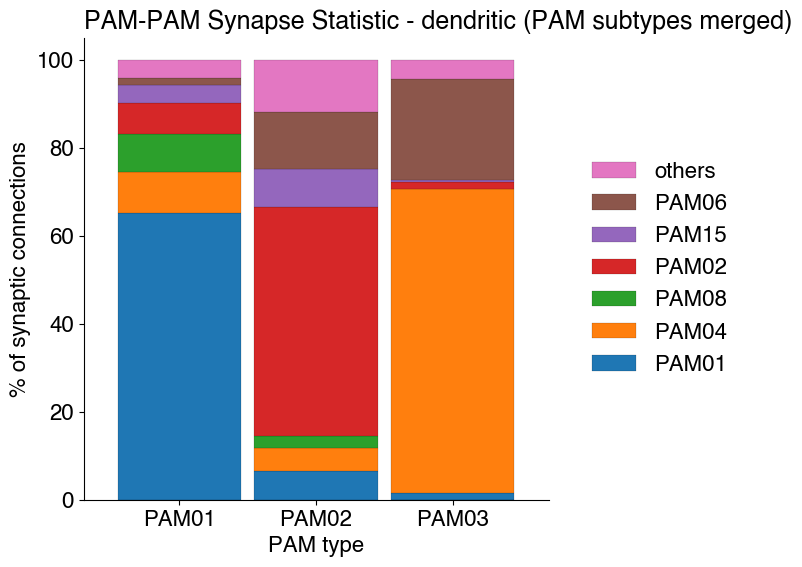

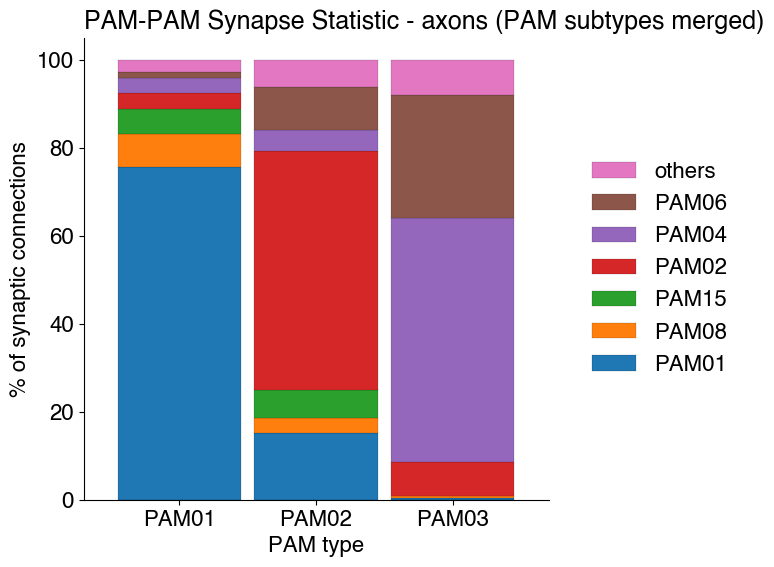

In [432]:

targets = ["PAM01", "PAM02", "PAM03"]
partnerType = "type" ## instance, type, bodyId
treshhold= 0.03
plotPAMStatistic(targets=targets,etcTreshhold=treshhold,partnerType=partnerType,mergePAMSubtypes=True)

In [373]:
### retrieving all connections between PAM and non-PAM neurons
filteredPAMConnections = getFilteredConnections("^PAM.*","^.*", minWeight=1)
typePartners, instancePartners, bodyIdPartners = listUniqueConnectionPartners(filteredPAMConnections,type="pre")
typePartners, instancePartners, bodyIdPartners = listUniqueConnectionPartners(filteredPAMConnections,type="post")

  0%|          | 0/2 [00:00<?, ?it/s]

Unique connection partners
by type
['PAM09' 'PAM10' 'PAM04_a' 'PAM04_b' 'PAM01_b' 'PAM11' 'PAM01_a' 'PAM05'
 'PAM08_c' 'PAM08_e' 'PAM02' 'PAM06_b' 'PAM14' 'PAM13' 'PAM06_a' 'PAM08_b'
 'PAM12' 'PAM03' 'PAM08_a' 'PAM07' 'PAM08_d' 'PAM15_a' 'PAM15_b']
by instance
['PAM09(B1ped)_L' 'PAM10(B1)_R' 'PAM09(B1ped)_R' 'PAM10(B1)_L'
 'PAM04_a(B2)_R' 'PAM04_b(B2)_R' 'PAM01_b(y5)_R' 'PAM11(a1)_R'
 'PAM01_a(y5)_R' "PAM05(B'2p)_R" 'PAM01_a(y5)_L' 'PAM04_a(B2)_L'
 'PAM11(a1)_L' 'PAM08_c(y4)_R' 'PAM08_e(y4)_R' 'PAM01_b(y5)_L'
 "PAM02(B'2a)_L" "PAM05(B'2p)_L" "PAM06_b(B'2m)_R" "PAM14(B'1m)_R"
 "PAM13(B'1ap)_R" "PAM06_a(B'2m)_R" "PAM06_a(B'2m)_L" "PAM02(B'2a)_R"
 "PAM14(B'1m)_L" "PAM13(B'1ap)_L" 'PAM08_b(y4)_L' "PAM06_b(B'2m)_L"
 'PAM12(y3)_R' "PAM03(B2B'2a)_L" 'PAM12(y3)_L' 'PAM08_e(y4)_L'
 'PAM08_b(y4)_R' 'PAM08_c(y4)_L' 'PAM08_a(y4)_R' 'PAM07(y4<y1y2)_L'
 'PAM08_a(y4)_L' 'PAM07(y4<y1y2)_R' "PAM03(B2B'2a)_R" 'PAM08_d(y4)_R'
 "PAM15_a(y5B'2a)_L" "PAM15_b(y5B'2a)_R" 'PAM04_b(B2)(ADM02)_L'
 'PAM08_d(y4)_L

In [418]:
##testing whether connections make sense
extractDendritesPerType(target="PAM05",connections=filteredPAMConnections)
extractAxonsPerType(target="PAM05",connections=filteredPAMConnections)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
7783,517207902,268725517,b'L(L),1,PAM05,PAM05(B'2p)_R,PAM09,PAM09(B1ped)_L
7784,517207902,268731005,b'L(R),1,PAM05,PAM05(B'2p)_R,SMP146,SMP146(ADM10)_L
7785,517207902,361722354,SMP(R),1,PAM05,PAM05(B'2p)_R,SMP081,SMP081_R
7786,517207902,387568523,b'L(R),1,PAM05,PAM05(B'2p)_R,LHPD5d1,LHPD5d1_R
7787,517207902,425276848,b'L(L),6,PAM05,PAM05(B'2p)_R,DPM,DPM_L
...,...,...,...,...,...,...,...,...
72859,5901205545,5813095018,b'L(R),2,PAM05,PAM05(B'2p)_L,KCa'b'-ap2,KCa'b'-ap2_R
72860,5901205545,5813105172,b'L(R),10,PAM05,PAM05(B'2p)_L,DPM,DPM_R
72861,5901205545,5813110459,b'L(R),3,PAM05,PAM05(B'2p)_L,KCa'b'-ap1,KCa'b'-ap1_R
72862,5901205545,5813111042,b'L(R),1,PAM05,PAM05(B'2p)_L,KCa'b'-ap1,KCa'b'-ap1_R


       bodyId_pre  bodyId_post     roi  weight type_pre  instance_pre  \
0       268725517    298595394   bL(R)       2      PAM  PAM(B1ped)_L   
1       268725517    298595394  b'L(R)       1      PAM  PAM(B1ped)_L   
2       268725517    298595394   bL(L)       1      PAM  PAM(B1ped)_L   
3       268725517    299613480   bL(R)       1      PAM  PAM(B1ped)_L   
4       268725517    328253133   bL(L)       1      PAM  PAM(B1ped)_L   
...           ...          ...     ...     ...      ...           ...   
72859  5901205545   5813095018  b'L(R)       2      PAM   PAM(B'2p)_L   
72860  5901205545   5813105172  b'L(R)      10      PAM   PAM(B'2p)_L   
72861  5901205545   5813110459  b'L(R)       3      PAM   PAM(B'2p)_L   
72862  5901205545   5813111042  b'L(R)       1      PAM   PAM(B'2p)_L   
72863  5901205545   5813112511  b'L(R)       2      PAM   PAM(B'2p)_L   

        type_post instance_post  
0             PAM     PAM(B1)_R  
1             PAM     PAM(B1)_R  
2             PAM    

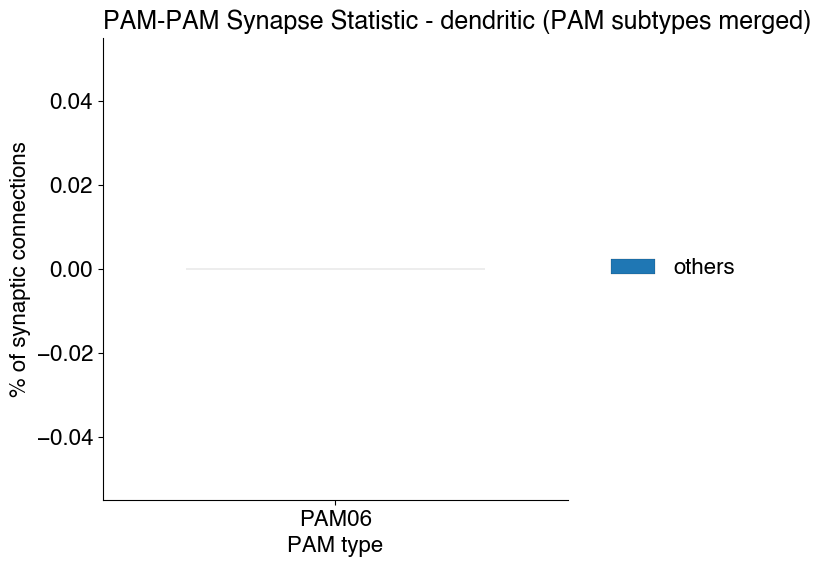

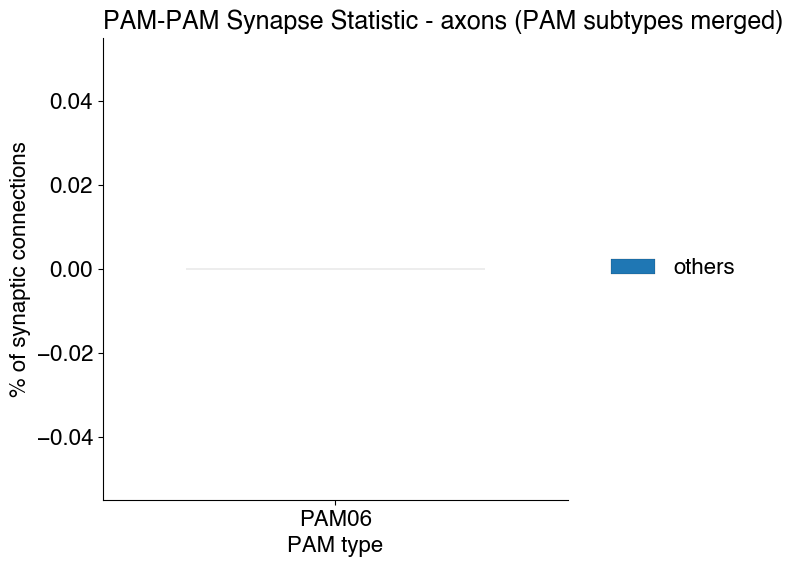

In [436]:
### 
targets = ["PAM04", "PAM05","PAM06"]
partnerType = "type" ## instance, type, bodyId
treshhold= 0.02
plotPAMStatistic(connections=filteredPAMConnections,targets=targets,etcTreshhold=treshhold,partnerType=partnerType,normalized=False, mergePAMSubtypes = True, mergePAMs = True)

TODO FIX PAM MERGING IN collapseConnections ()

#### Visualization of PAM-PAM synapses
TODO implement filteing based on neurotransmitter type DA  


In [14]:
# RETRIEVE ALL PAM-PAM SYNAPSES

## get PAM neurons 
neuron_criteria = NC(status='Traced', type="^PAM.*",regex=True)

## get all synapses, within and outside MB
allpresynapses_criteria = SC(type='pre', primary_only=True)
allpostsynapses_criteria = SC(type='post', primary_only=True)
allpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, allpresynapses_criteria,batch_size=10000)
allpostsynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, allpostsynapses_criteria,batch_size=10000)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10509 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10509 [00:00<?, ?it/s]

In [16]:
#fetch mesh for mushroombody..
mb_mesh = neu.fetch_roi('MB')
mb_mesh.color = (.9, .9, .9, .75) #,(.9, .9, .9, .05)


# Generate 2D outlines for roi
def get_outlines(roi, view = 'xz'):
    roi2d = np.array(roi.to_2d(alpha = 2,view = view))
    roi_outlines = np.append(roi2d, np.repeat(roi.center[2], roi2d.shape[0]).reshape(roi2d.shape[0], 1), axis=1)
    return roi_outlines

mb_outlines = get_outlines(mb_mesh)



AttributeError: 'Delaunay' object has no attribute 'vertices'

In [ ]:
fig, ax = navis.plot2d([mb_outlines],method='2d', view=('x','-z'), connectors=True, color = 'black', linewidth=2, alpha = 0.5)


NameError: name 'navis' is not defined

In [ ]:
# Plot the synapse positions in a 2D projection
## blue synapses are MB synapses, red are outside the MB
title = "PAM-PAM synapses (blue: pre ("+(allpresynapses.index.size.__str__())+"), red: post("+allpostsynapses.index.size.__str__()+"))"
p = figure(title=title)
p.scatter(allpresynapses['x_post'], allpresynapses['z_post'], color="blue")
p.scatter(allpostsynapses['x_post'], allpostsynapses['z_post'], color="red")
p.y_range.flipped = True
show(p)

p = figure(title=title)
p.scatter(allpresynapses['x_post'], allpresynapses['y_post'], color="blue")
p.scatter(allpostsynapses['x_post'], allpostsynapses['y_post'], color="red")
p.y_range.flipped = True
show(p)



In [38]:
print("Printing ROIs with PAM-PAM presynapses")
print(sorted(filter(None, allpresynapses["roi_pre"].unique())))
print(sorted(filter(None, allpostsynapses["roi_pre"].unique())))
print("\nPrinting ROIs with PAM-PAM postsynapses")
print(sorted(filter(None, allpresynapses["roi_post"].unique())))
print(sorted(filter(None, allpostsynapses["roi_post"].unique())))


Printing ROIs with PAM-PAM presynapses
['CRE(L)', 'CRE(R)', 'EB', 'LAL(L)', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']
['CRE(L)', 'CRE(R)', 'EB', 'LAL(L)', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']

Printing ROIs with PAM-PAM postsynapses
['CRE(L)', 'CRE(R)', 'EB', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']
['CRE(L)', 'CRE(R)', 'EB', 'LAL(R)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']


In [49]:
noneRoiPresynapses = allpresynapses[allpresynapses["roi_post"].isnull()]
noneRoiPostsynapses = allpostsynapses[allpostsynapses["roi_post"].isnull()]

### analyzing MB and non-MB synapses

In [33]:
## get PAM neurons 
neuron_criteria = NC(status='Traced', type="^PAM.*",regex=True)

In [34]:
## get synapses within MB
MB_rois=["a'L(R)","aL(R)","b'L(R)","bL(R)","gL(R)","CA(L)","a'L(L)","aL(L)","b'L(L)","bL(L)","gL(L)", "CA(R)", "PED(R)"]
MBpresynapses_criteria = SC(type='pre', primary_only=True,rois=MB_rois)
MBpostsynapses_criteria = SC(type='post', primary_only=True,rois=MB_rois)
MBpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, MBpresynapses_criteria)
MBpostynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, MBpostsynapses_criteria)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9716 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9716 [00:00<?, ?it/s]

In [35]:
## get synapses outside MB
non_MB_rois=["CRE(L)", "CRE(R)", "EB", "LAL(R)", "SIP(L)", "SIP(R)", "SLP(R)", "SMP(L)", "SMP(R)", "LAL(L)"]
nonMBpresynapses_criteria = SC(type='pre', primary_only=True,rois=non_MB_rois)
nonMBpostsynapses_criteria = SC(type='post', primary_only=True,rois=non_MB_rois)
nonMBpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, nonMBpresynapses_criteria)
nonMBpostynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, nonMBpostsynapses_criteria)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

##### Visualization of PAM-PAM synapses inside/outside MB

In [52]:
# Plot the synapse positions in a 2D projection
## blue synapses are MB synapses, red are outside the MB
title = "PAM-PAM synapses (blue: MB, red: non-MB, green: ROI 'None')"
p = figure(title=title)
p.scatter(MBpresynapses['x_post'], MBpresynapses['z_post'], color="blue")
p.scatter(nonMBpresynapses['x_post'], nonMBpresynapses['z_post'], color="red")
p.scatter(noneRoiPresynapses['x_post'], MBpresynapses['z_post'], color="green")
p.y_range.flipped = True
show(p)

p = figure(title=title)
p.scatter(MBpresynapses['x_post'], MBpresynapses['y_post'], color="blue")
p.scatter(nonMBpresynapses['x_post'], nonMBpresynapses['y_post'], color="red")
p.scatter(noneRoiPresynapses['x_post'], nonMBpresynapses['y_post'], color="green")
p.y_range.flipped = True
show(p)



### analysis of connection details

      bodyId_pre  bodyId_post roi_pre roi_post  x_pre  y_pre  z_pre  x_post  \
0      735282133    268725517   bL(L)    bL(L)  34285  31311  19613   34280   
1      735282133    268725517   bL(L)    bL(L)  33984  30918  19675   33983   
2      643535876    268725517  b'L(R)   b'L(R)  17457  31462  19102   17439   
3      643535876    268725517  b'L(R)   b'L(R)  17638  31333  19170   17616   
4      582148591    268725517   bL(L)    bL(L)  33925  32365  20704   33925   
...          ...          ...     ...      ...    ...    ...    ...     ...   
9711  1169993905   5901205545  b'L(R)   b'L(R)  20868  28680  17471   20885   
9712  1169989859   5901205545  b'L(L)   b'L(L)  29476  27314  17042   29464   
9713  1139724251   5901205545  b'L(L)   b'L(L)  29683  27209  17034   29674   
9714  1081767446   5901205545  b'L(L)   b'L(L)  31121  29357  16942   31109   
9715  1081767446   5901205545  b'L(L)   b'L(L)  29165  28320  16559   29157   

      y_post  z_post  confidence_pre  confidence_po

NameError: name 'coneuronssorted_df' is not defined

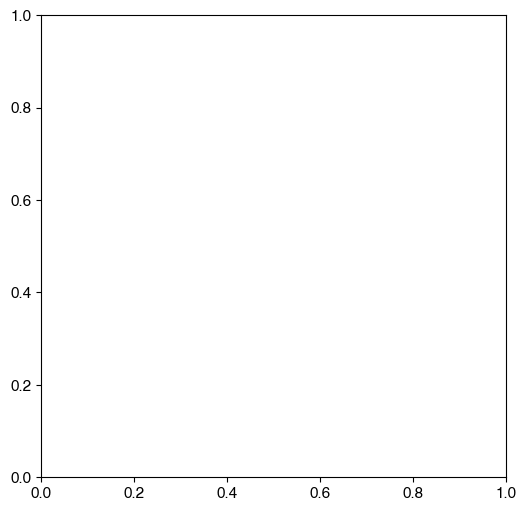

In [53]:
fig = plt.figure(figsize=(6, 6))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])
ax = coneuronssorted_df.T.plot(kind='bar', stacked=True, ax = ax, linewidth=0.1, width = 0.9, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', 
          bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize},frameon=False)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
# plt.box(False)
# ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('target MBON',fontsize=label_fontsize, weight = 'bold')
ax.set_ylabel('percentage of co-neurons in postsynapses',fontsize=label_fontsize, weight = 'bold')
plt.savefig('figures/mbon_parsing_specificity.png', dpi=300, bbox_inches='tight')
